==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights


MODULE data UNDEFINED


conv1: 96 3 11 11
conv2: 256 48 5 5


conv3: 384 256 3 3


conv4: 384 192 3 3


conv5: 256 192 3 3


fc6: 1 1 9216 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading image and imagenet mean	


==> Preprocessing	


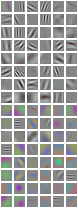

In [1]:
require 'loadcaffe'
require 'image'



-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 

prototxt_name = '/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights'

--prototxt_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/deploy.prototxt'
--binary_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/bvlc_alexnet.caffemodel'

print '==> Loading network'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading image and imagenet mean'
--image_name = 'Goldfish3.jpg'
image_name = 'lena.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

net:forward(I:cuda())

itorch.image( net:get(1).weight )


 96
 54
 54
[torch.LongStorage of size 3]



==> Scatter Time elapsed: 0.027896165847778 seconds	


==> Time elapsed: 0.02984619140625 seconds	

   1
   3
 224
 224
[torch.LongStorage of size 4]



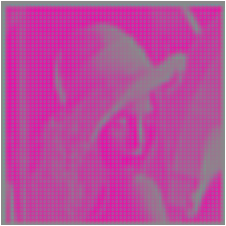

torch.CudaTensor	


In [3]:
-- Deconvolution
require 'modules/SpatialDeconvolution'

--print(I:size(2))

deconv1 = cudnn.SpatialDeconvolution( net:get(1), I:size(2), 86 )
conv1_fm = net:get(1).output
print(conv1_fm:size())

timer = torch.Timer()
deconv1_fm = deconv1:forward(conv1_fm) 
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
print(deconv1_fm:size())
itorch.image(deconv1_fm:float())
print(deconv1.weight:type())

==> Scatter Time elapsed: 0.013235092163086 seconds	


==> Time elapsed: 0.014827966690063 seconds	


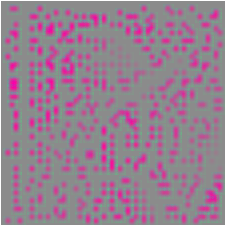

In [6]:
-- Unpooling and Deconvolution
require 'modules/SpatialUnPooling'


pool1_fm = net:get(3).output
timer = torch.Timer()
unpool1 = cudnn.SpatialUnPooling(net:get(3), conv1_fm )
unpool1_fm = unpool1:forward(pool1_fm)
deconv1_unpool1_fm = deconv1:forward(unpool1_fm)
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
itorch.image(deconv1_unpool1_fm:float())

In [ ]:
Deconv